In [1]:
import os, sys

import numpy as np
import matplotlib.pyplot as plt

from scipy.special import logit
from scipy.special import expit as sigmoid

In [2]:
from optim import Problem
from optim.utils import default_bounds
from optim.solver.gradient import SolverGradient

In [3]:
class ParametrizationIdentity:
    def __init__(self):
        self.bounds = default_bounds()
        
    def __call__(self, x):
        return x
    
    def inverse(self, x):
        return x


class ParametrizationExp:
    def __init__(self):
        self.bounds = default_bounds()
        
    def __call__(self, x):
        return -np.exp(x)
    
    def inverse(self, x):
        esp = 1e-300
        return np.log(-x + eps)
    
    
class ParametrizationLogit:
    def __init__(self):
        from scipy.optimize import Bounds
        self.bounds = Bounds(0, 1, keep_feasible=True)
        
    def __call__(self, x):
        return logit(x)
    
    def inverse(self, x):
        return sigmoid(x)

Let's use the Rosenbrock function to illustrate how to solve an optimization problem.

$$ f(x) = (a - x_1)^2 + b \cdot (x_2 - x_1^2)^2 $$

This function has the global minimum at $x_{min} = (1, 1)$, and it is widely used for comparing optimization algorithms.

In [4]:
# Rosenbrock function
a = 1
b = 10
function_to_minimize = lambda x: (a - x[0])**2 + b * (x[1] - x[0]**2)**2

In [5]:
x_range = (-2, 3)
y_range = (-2, 6)

X = np.arange(*x_range, step=0.1)
Y = np.arange(*y_range, step=0.1)

X, Y = np.meshgrid(X, Y)
Z = function_to_minimize([X, Y])

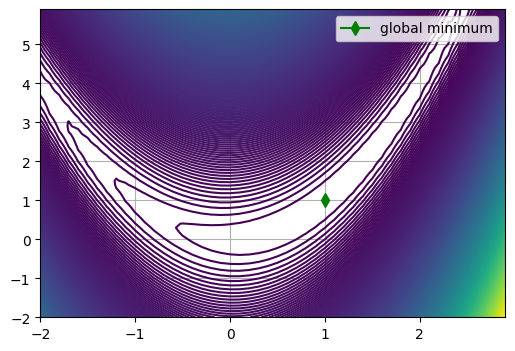

In [6]:
plt.figure(figsize=(6, 4));

plt.contour(X, Y, Z, levels=500);
plt.plot([1.0], [1.0], marker="d", markersize=7, color="green", label="global minimum");
plt.legend();
plt.grid();

Let's define an optimization problem. First, we define the objective function.

In [7]:
class ProblemRosenbrock(Problem):
    def __init__(self):
        super().__init__()
        
    def objective(self, x):
        return function_to_minimize(x)

Next, we define a parametrization and bounds for variables. 

In [8]:
#---------------------------------------Problem---------------------------------------
problem = ProblemRosenbrock()

# parametrization = None
parametrization = ParametrizationIdentity()

problem.set_parametrization(parametrization)

bounds = None
problem.add_bounds(bounds)

Finally, we use a solver to find a solution

In [9]:
#---------------------------------------Solver---------------------------------------
solver = SolverGradient(problem)
solver.prepare(method="trust-constr", maxiter=100)

x_init = np.array([-1, -1])

x_sol = solver.solve(parametrization.inverse(x_init), seed=42)
x_sol = parametrization(x_sol)
print("Solution:", x_sol)

Solution: [0.99999954 0.99999907]


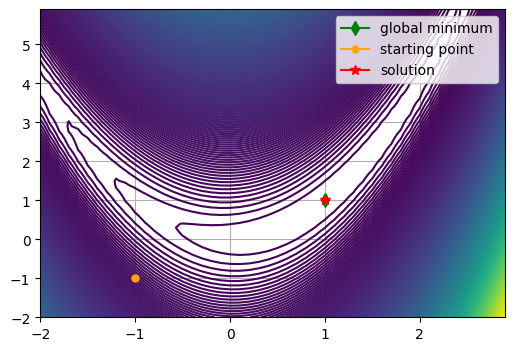

In [10]:
#---------------------------------------Solution---------------------------------------
plt.figure(figsize=(6, 4));

plt.contour(X, Y, Z, levels=500);

plt.plot([1.0], [1.0], marker="d", markersize=7, color="green", label="global minimum");
plt.plot([x_init[0]], [x_init[1]], marker="o", markersize=5, color="orange", label="starting point");
plt.plot([x_sol[0]], [x_sol[1]], marker="*", markersize=7, color="red", label="solution");

plt.legend();
plt.grid();

Let's use an alternative parametrization, for the sake of demonstration.

Solution: [0.9999968  0.99999353]


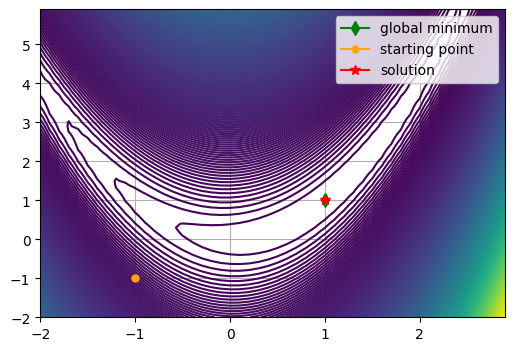

In [11]:
#---------------------------------------Problem---------------------------------------
problem = ProblemRosenbrock()

# parametrization = None
# parametrization = ParametrizationIdentity()
# parametrization = ParametrizationExp()
parametrization = ParametrizationLogit()
bounds = parametrization.bounds

problem.set_parametrization(parametrization)
problem.add_bounds(bounds)

#---------------------------------------Solver---------------------------------------
solver = SolverGradient(problem)
solver.prepare(method="trust-constr", maxiter=100)

x_init = np.array([-1, -1])

x_sol = solver.solve(parametrization.inverse(x_init), seed=42)
x_sol = parametrization(x_sol)
print("Solution:", x_sol)

#---------------------------------------Solution---------------------------------------
plt.figure(figsize=(6, 4));

plt.contour(X, Y, Z, levels=500);

plt.plot([1.0], [1.0], marker="d", markersize=7, color="green", label="global minimum");
plt.plot([x_init[0]], [x_init[1]], marker="o", markersize=5, color="orange", label="starting point");
plt.plot([x_sol[0]], [x_sol[1]], marker="*", markersize=7, color="red", label="solution");

plt.legend();
plt.grid();

Now, let's bound the variable to be non-positive: $x_i \in (-\infty, 0]$.

Solution: [-3.20100878e-06 -8.35589830e-04]


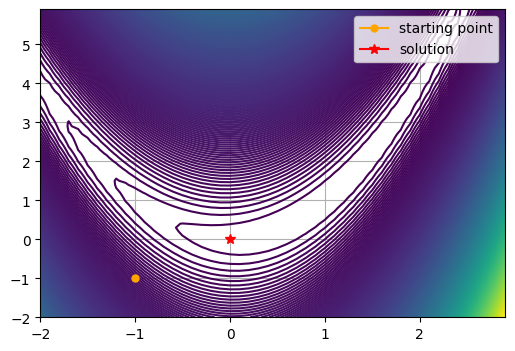

In [12]:
#---------------------------------------Problem---------------------------------------
problem = ProblemRosenbrock()

# parametrization = None
parametrization = ParametrizationIdentity()

problem.set_parametrization(parametrization)

bounds = [(-np.inf, 0), (-np.inf, 0)]
problem.add_bounds(bounds)

#---------------------------------------Solver---------------------------------------
solver = SolverGradient(problem)
solver.prepare(method="trust-constr", maxiter=100)

x_init = np.array([-1, -1])

x_sol = solver.solve(parametrization.inverse(x_init), seed=42)
x_sol = parametrization(x_sol)
print("Solution:", x_sol)

#---------------------------------------Solution---------------------------------------
plt.figure(figsize=(6, 4));

plt.contour(X, Y, Z, levels=500);

plt.plot([x_init[0]], [x_init[1]], marker="o", markersize=5, color="orange", label="starting point");
plt.plot([x_sol[0]], [x_sol[1]], marker="*", markersize=7, color="red", label="solution");
plt.legend();
plt.grid();

Finally, let's add a nonlinear constraint in the following form: $g(x) \leq 0$.

Solution: [0.36119027 0.14282113]


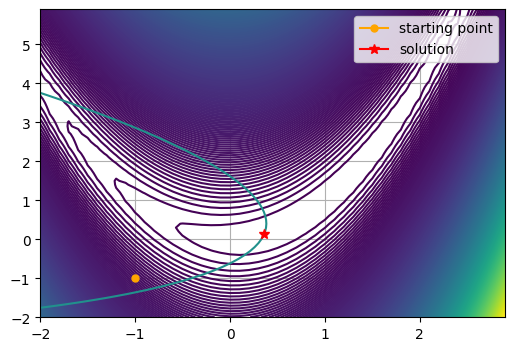

In [13]:
#---------------------------------------Problem---------------------------------------
problem = ProblemRosenbrock()

# parametrization = None
parametrization = ParametrizationIdentity()

problem.set_parametrization(parametrization)

constraint = lambda x: 1 * x[0]**2 + 5*x[0]*x[1] + 10*x[1]**2 + 30*x[0] - 10*x[1] - 10
problem.add_constraint(constraint)

problem.add_bounds(None)

#---------------------------------------Solver---------------------------------------
solver = SolverGradient(problem)
solver.prepare(method="trust-constr", maxiter=100)

x_init = np.array([-1, -1])

assert constraint(x_init) <= 0 # check feasibility

x_sol = solver.solve(parametrization.inverse(x_init), seed=42)
x_sol = parametrization(x_sol)
print("Solution:", x_sol)

#---------------------------------------Solution---------------------------------------
plt.figure(figsize=(6, 4));

plt.contour(X, Y, Z, levels=500);

plt.contour(X, Y, constraint([X, Y]), levels=0);

plt.plot([x_init[0]], [x_init[1]], marker="o", markersize=5, color="orange", label="starting point");
plt.plot([x_sol[0]], [x_sol[1]], marker="*", markersize=7, color="red", label="solution");
plt.legend();
plt.grid();